In [1]:
import glob

from skimage.transform import resize
from skimage import data, color

import keras.backend as K
from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers import Input,Dense,Reshape, Flatten, Conv2DTranspose, Dropout,BatchNormalization,Activation,PReLU,LeakyReLU,MaxoutDense
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D

from keras.optimizers import Adam,RMSprop
from keras import initializers
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import os


Using TensorFlow backend.


### Helper methods ###

In [2]:
def save_loss(name, epoch, Dloss, Gloss):
    if not os.path.exists('loss/'+name):
        os.mkdir('loss/'+name)
    plt.figure(figsize=(10,8))
    plt.plot(Dloss,label='Dsicriminiative loss')
    plt.plot(Gloss,label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss/'+name+'/loss_%d.png' % epoch)
    
def save_samples(folder, w, h, c, epoch, G,example=16,dim=(10,10),figsize=(10,10), randomDim=100):
    noise = np.random.normal(0,1,size=(example,randomDim))
    generatedImage = G.predict(noise)
    
    plt.figure(figsize=figsize)
    
    for i in range(example):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow((generatedImage[i]* 127.5+127.5).astype(np.int32),interpolation='nearest',cmap='gray')
        '''drop the x and y axis'''
        plt.axis('off')
    plt.tight_layout()
    
    path = 'results/'+folder
    if not os.path.exists(path):
        os.mkdir(path)
    plt.savefig(path+'/epoch_%d.png' % epoch)
    
def save_models(name, epoch, d=None, g=None):
    path = 'models/'+name
    if not os.path.exists(path):
        os.mkdir(path)
    g.save(path+'/G_%d.h5' % epoch)
    d.save(path+'/D_%d.h5' % epoch)
    
def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

### Wasserstein loss ###

In [3]:
def wasserstein_loss(y_true,y_pred):
    return K.mean(y_true*y_pred)

### Final critic

In [4]:
def create_critic_final(width, height, channels, kernel_size=3):
    """ Declare discriminator """

    model = Sequential()

    model.add(Conv2D(32, kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2), 
                     kernel_size=kernel_size, strides=2, 
                     input_shape=(width, height, channels), padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Dense(1))

    print('Critic')
    model.summary()
    model.compile(loss=wasserstein_loss,optimizer=RMSprop(lr=0.00005))

    return model

### Final actor ###

In [5]:
def create_actor_final(width, height, channels, latent_dim=100):
    model = Sequential()

    model.add(Dense(32*int(width/4)*int(height/4), input_dim=latent_dim,
                    kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
    model.add(Reshape((int(width/4),int(height/4), 32)))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(48, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
    
    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
 
    model.add(Conv2D(8, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
    
    model.add(Conv2D(channels, kernel_size=3, strides=1, padding="same"))
    model.add(Activation("tanh"))
    
    print('Actor')
    model.summary()    
    
    return model

### Training method ###

In [6]:
def train(name, data_path, critic, actor, epochs=3000, batchsize=64, save_loss=True, save_models=True, save_samples=True, batchCount=128, epoch_offset=0):
    """
    :name: name of the directory, which will store all data
    :data_path: path to real samples
    :critic: model for critic
    :actor: model for critic
    """

    filelist = glob.glob(os.path.join(data_path,'*.jpg'))
    image_number = len(filelist)


    width, height, channels = 256, 256, 3

    randomDim = 100

    generator = actor
    discriminator = critic

    discriminator.trainable = False
    gan_input = Input((randomDim,))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(gan_input,gan_output)
    gan.compile(loss=wasserstein_loss,optimizer=RMSprop(lr=0.00005))

    Dloss = []
    Gloss = []

    print('Actor', get_model_memory_usage(batchsize, generator), 'GB')
    print('Critic', get_model_memory_usage(batchsize*2, discriminator), 'GB')
    
    print('Epochs',epochs)
    print('Bathc size',batchsize)
    print('Batches per epoch',batchCount)

    for e in range(epoch_offset+1,epochs+1):
        print('-'*15 , 'Epoch %d' % e , '-'*15)
        for _ in range(batchCount):
            print('.', end='')
            random_index = np.random.randint(0, image_number - batchsize)
            imageBatch = np.array([crop_center(data.imread(fname), width, height) for fname in filelist[random_index : random_index + batchsize]]).reshape(batchsize, width, height, channels)
            imageBatch = (imageBatch.astype(np.float32) - 127.5) / 127.5
            
            #Get a random set of input noise and images
            noise = np.random.normal(0,1,size=[batchsize,randomDim])
            generatedImages = generator.predict(noise)
            
            X = np.concatenate([imageBatch,generatedImages])
            
            yDis = np.ones(2*batchsize)
            
            yDis[:batchsize] = -1
            
            #Train critic
            discriminator.trainable = True
            
            ### Clip weights ###
            weights = [np.clip(w, -0.01, 0.01) for w in discriminator.get_weights()]
            discriminator.set_weights(weights)
            
            dloss = discriminator.train_on_batch(X,yDis)
            
            #Train actor
            noise = np.random.normal(0,1,size=[batchsize,randomDim])
            yGen = np.ones(batchsize) * -1
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise,yGen)
            

        if save_loss:
            Dloss.append(dloss)
            Gloss.append(gloss)
            save_loss(name, e, Dloss, Gloss)
        if save_samples:
            save_samples(name, width, height, channels, e, generator, 16, dim=(4,4))
        if save_models:
            save_models(name, e, d=discriminator, g=generator)


In [ ]:
critic = create_critic_final(256, 256, 3)
actor = create_actor_final(256, 256, 3)
train('WGAN', 'normal', critic, actor, 3000, 64)

In [7]:
saved_actor = load_model('models/actor_final.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


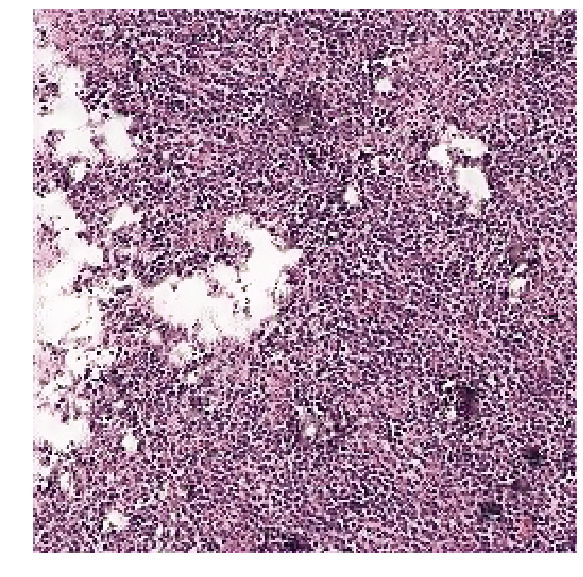

In [10]:
noise = np.random.normal(0,1,size=(1,100))
imgs = saved_actor.predict(noise)

plt.figure(figsize=(20,10))

plt.axis('off')

plt.imshow((imgs[0]*1* 127.5+127.5).astype(np.int32))
